In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import gensim
from tqdm import tqdm
import os
from gensim.models.fasttext import FastText

In [3]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
MAX_NB_WORDS = 500000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [6]:
cd  "/content/drive/My Drive/iiit_ire/word2vec_fasttext"

/content/drive/My Drive/iiit_ire/word2vec_fasttext


In [7]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

[=================================================-] 99.0% 1646.4/1662.8MB downloaded


In [8]:
import json 
traind=[]
vald=[]
dir = "/content/drive/My Drive/iiit_ire/data/"
# Opening JSON file 
with open(dir+'FinNum_training_v3.json',) as f: 
  traind = json.load(f) 
with open(dir+'FinNum_dev_v3.json',) as f: 
  vald = json.load(f) 

train = pd.DataFrame(traind) 
val = pd.DataFrame(vald) 
print(train.shape, val.shape)


(7187, 5) (1044, 5)


In [9]:
cols = ['tweet', 'relation']
train = train[cols]
val = val[cols]

In [10]:
print(train.relation.value_counts())
print(val.relation.value_counts())

1    5827
0    1360
Name: relation, dtype: int64
1    850
0    194
Name: relation, dtype: int64


In [11]:
train.head()

,tweet,relation
0,"$XXII Scott Gottlieb, Commissioner of FDA spee...",1
1,$TSLA Maybe they calculate that 7ct energy pri...,1
2,$RAD about 9 million more shares than the 90 d...,1
3,$DPW that was quite a roller coaster. Glad it ...,1
4,$GILD Good thing the market sets new record hi...,1


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


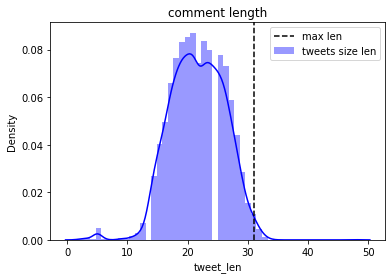

In [12]:
train['tweet_len'] = train.tweet.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train.tweet_len.mean() + 2*train.tweet_len.std()).astype(int)

sns.distplot(train.tweet_len, hist=True, kde=True, color='b', label='tweets size len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [13]:
label_dict = {}
for index, possible_label in enumerate(train.relation.unique()):
    label_dict[possible_label] = index

l_train = train.tweet.tolist()
l_test = val.tweet.tolist()
num_classes = len(label_dict)


clean_train = []
for doc in tqdm(l_train):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_train.append(" ".join(filtered))


clean_test = []
for doc in tqdm(l_test):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_test.append(" ".join(filtered))

print("Tokenizing: ")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_train + clean_test)  
word_seq_train = tokenizer.texts_to_sequences(clean_train)
word_seq_test = tokenizer.texts_to_sequences(clean_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

100%|██████████| 1044/1044 [00:00<00:00, 3873.37it/s]


Tokenizing: 
dictionary size:  12136


In [14]:
word_seq_train[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 8249,  157,  309,  234,  191,    9,
          7, 1350,   54,   46,    1,   11,  358,   14, 2245], dtype=int32)

In [15]:

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [16]:
def get_embedding(word):
    try:
        embedding=model[word]
    except:
        embedding=np.zeros((embed_dim,))
    return embedding

In [17]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = get_embedding(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        if np.sum(embedding_vector) == 0:
          words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 4675


In [18]:
print(words_not_found[50:100])

['to', 'gdxj', 'seekingalpha', '33', 'hmny', '45', '21', 'trxc', 'uvxy', '70', 'bzun', 'nugt', '35', '300', '09', '67', 'tlt', '90', 'dcix', '32', '52', '28', '08', 'uup', 'nflx', '23', '27', 'wti', '55', 'slv', 'xlf', 'ibb', 'wstl', '05', '31', '48', 'chfs', '2016', 'glbs', 'intc', '04', 'dgaz', 'xrp', 'teum', 'eoy', 'vrx', 'xnet', '10k', '400', '57']


In [19]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [30]:
# avoid model to overwrite
keras.backend.clear_session()

In [31]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256,return_sequences= True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(256,return_sequences= True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           3641100   
_________________________________________________________________
dropout (Dropout)            (None, 31, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 31, 512)           1140736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 512)           1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1

In [32]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.0002), metrics=['accuracy'])

In [33]:
!pwd

/content/drive/My Drive/iiit_ire/word2vec_fasttext


In [34]:
checkpoint = ModelCheckpoint('word2vec_vanilla_sent_weights.best.hdf5',
                             verbose=1,
                             save_weights_only=True,
                             monitor = 'val_accuracy',
                             mode='max',
                             save_best_only=True)

In [35]:
es_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode="max")
#training params
batch_size = 64 
num_epochs = 30

history = model.fit(word_seq_train, train.relation.values, batch_size=batch_size,
          epochs=num_epochs, validation_data=(word_seq_test, val.relation.values), 
          callbacks=[es_callback, checkpoint])#, steps_per_epoch=train.shape[0] // batch_size,
          # shuffle=False)

Epoch 1/30
111/113 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8163
Epoch 00001: val_accuracy improved from -inf to 0.85632, saving model to word2vec_vanilla_sent_weights.best.hdf5
113/113 [==============================] - 5s 48ms/step - loss: 0.4510 - accuracy: 0.8159 - val_loss: 0.3486 - val_accuracy: 0.8563
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8439
Epoch 00002: val_accuracy improved from 0.85632 to 0.86207, saving model to word2vec_vanilla_sent_weights.best.hdf5
113/113 [==============================] - 4s 32ms/step - loss: 0.3854 - accuracy: 0.8439 - val_loss: 0.3432 - val_accuracy: 0.8621
Epoch 3/30
111/113 [============================>.] - ETA: 0s - loss: 0.3572 - accuracy: 0.8604
Epoch 00003: val_accuracy did not improve from 0.86207
113/113 [==============================] - 3s 30ms/step - loss: 0.3571 - accuracy: 0.8603 - val_loss: 0.3557 - val_accuracy: 0.8563
Epoch 4/30
113/113 [============

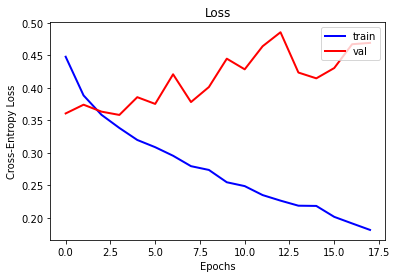

In [26]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

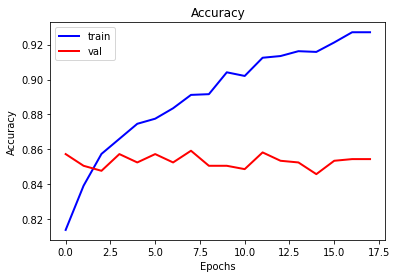

In [27]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [36]:

model.load_weights('word2vec_vanilla_sent_weights.best.hdf5')

In [44]:
predictions = model.predict_classes(word_seq_test)

In [38]:
predictions[:10].ravel()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [39]:
np.array(train.relation.values[:10])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(np.array(val.relation.values), predictions.ravel(), labels=[0,1]))
print(classification_report(np.array(val.relation.values), predictions.ravel()))

[[ 60 134]
 [ 10 840]]
              precision    recall  f1-score   support

           0       0.86      0.31      0.45       194
           1       0.86      0.99      0.92       850

    accuracy                           0.86      1044
   macro avg       0.86      0.65      0.69      1044
weighted avg       0.86      0.86      0.83      1044



In [41]:
predictions = model.predict_classes(word_seq_train)
print(confusion_matrix(np.array(train.relation.values), predictions.ravel(), labels=[0,1]))
print(classification_report(np.array(train.relation.values), predictions.ravel()))

[[ 612  748]
 [ 241 5586]]
              precision    recall  f1-score   support

           0       0.72      0.45      0.55      1360
           1       0.88      0.96      0.92      5827

    accuracy                           0.86      7187
   macro avg       0.80      0.70      0.74      7187
weighted avg       0.85      0.86      0.85      7187

